# **ACCIDENTOLOGY PROJECT: KAGGLE ESIEE 2023 - 2024**

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [256]:
pd.set_option('display.max_columns', None)

# **OPENING FILES**

In [257]:
def open_file(item):
   
    all_data = pd.DataFrame()

    #Loop on every Years
    for year in range(2012, 2023):
        path = f"TRAIN/BAAC-Annee-{year}/{item}_{year}_.csv"
        try:
            file = pd.read_csv(path, delimiter=';', index_col = 0,low_memory=False)
            all_data = pd.concat([all_data, file])
        except FileNotFoundError:
            print(f"File {path} was not found.")
        except Exception as e:
            print(f"Reading {path} create an error: {e}")

    return all_data

In [258]:
def create_dataframe():

    caracteristics = open_file('caracteristiques')
    localisation = open_file('lieux')
    users = open_file('usagers')
    vehicles = open_file('vehicules')

    return caracteristics,localisation,users,vehicles

In [259]:
caracteristics,localisation,users,vehicles = create_dataframe()

### **Isolation of the 'Grave' Column**

In [260]:
# Convert the 'grav' column to a numpy array
grav_array = users['grav'].values
num_acc_array = users['Num_Acc'].values

# Create an array for the presence of 'GRAVE'
is_grave = np.isin(grav_array, [2, 3])

# Use numpy ufuncs to create a mapping from 'Num_Acc' to 'GRAVE'
unique_nums, grave_presence = np.unique(num_acc_array, return_inverse=True)
result = np.bitwise_or.reduceat(is_grave, np.r_[0, np.where(np.diff(num_acc_array))[0]+1])

In [261]:
users.drop('grav',axis = 1,inplace = True)

In [262]:
# Création du DataFrame
df_grave = pd.DataFrame({
    'Num_Acc': unique_nums,
    'GRAVE': result
})

df_grave['GRAVE'] = df_grave['GRAVE'].astype(int)

### **Merge GRAVE + Dataframe :** 

In [263]:
def merge_grave(df):

    return df_grave.merge(df,on = "Num_Acc",how = 'left')

### **Analysis Function :**

In [264]:
def summary_info(df):

    # Creation of an Informative Dataframe
    return  pd.DataFrame({
        'NaN_Count': df.isna().sum().astype(int),
        'Nan_ratio': df.isna().mean().astype(float),
        '-1_Count': df.eq(-1).sum().astype(int),
        '0_Count': df.eq(0).sum().astype(int)
    })

### **Agglomeration Function :**

In [265]:
def column_aggreg(df, column):
    # One-hot encoding on the specified column
    one_hot_encoded = pd.get_dummies(df[column], prefix=column)

    # Add the 'Num_Acc' column to merge results later
    one_hot_encoded['Num_Acc'] = df['Num_Acc']

    # Aggregate results for each accident
    one_hot_encoded_grouped = one_hot_encoded.groupby('Num_Acc').sum().reset_index()

    # Merge these results with the initial DataFrame
    df = pd.merge(df, one_hot_encoded_grouped, on='Num_Acc', how='left')

    return df


# **USERS :**

## **PREPROCESSING :**

In [266]:
def users_del_(df):

    col_to_drop = ['id_vehicule','id_usager','secu2','secu3','actp']
    df = df.drop(col_to_drop,axis = 1)

    return df

In [267]:
def users_NaN_(df):

    col_to_replace = ['place','trajet']

    df[col_to_replace] = df[col_to_replace].replace(np.nan,-1)
    
    return df

In [268]:
def users_correction_(df):
    df['locp'] = df['locp'].replace(9, -1)
    df['trajet'] = df['trajet'].replace(0, -1)

    # Calculate the median excluding NaNs
    median_an_nais = df['an_nais'].median()

    # Replace NaNs with the median in the 'an_nais' column
    df['an_nais'] = df['an_nais'].fillna(median_an_nais)

    return df


In [269]:
def pedestrian_correction_(df):
    # Conditional replacement of values
    condition_3 = (df['catu'] == 3) & df['locp'].isna() & df['etatp'].isna()

    # Condition for catu != 3 and all relevant values are NaN
    condition_not_3 = (df['catu'] != 3) & df['locp'].isna() & df['etatp'].isna()

    # Apply the conditions to the three columns
    df.loc[condition_3, ['locp', 'etatp']] = -1
    df.loc[condition_not_3, ['locp', 'etatp']] = 0

    col_to_replace = ['locp', 'etatp']

    df[col_to_replace] = df[col_to_replace].replace(np.nan, -1)

    return df


In [270]:
def adjust_secu(value):
    if value in [1, 2, 3, 4, 9]:
        return -1
    elif value >= 10:
        tens = int(value // 10)
        units = int(value % 10)
        if units == 1:
            return tens
        elif units == 3:
            return 3
        elif units == 2:
            return 0
        else:
            return value  # If none of the other conditions are met, return the original value
    else:
        return value  # For negative cases and other undefined cases

def merge_columns(df):
    df['secu'] = df['secu'].fillna(df['secu1'])
    df['secu'] = df['secu'].replace([9, 4, 6, 5, 7], 0)
    df['secu'] = df['secu'].fillna(-1)
    df.drop(['secu1'], axis=1, inplace=True)
    
    return df


In [271]:
def usagers_preprocessing_(df):

    df = users_del_(df)
    df = users_NaN_(df)
    df = pedestrian_correction_(df)
    df = users_correction_(df)

    df['secu'] = df['secu'].apply(adjust_secu)
    df = merge_columns(df)

    cols_to_convert_category = ['place','catu','sexe','trajet','secu','locp','etatp','num_veh']

    df[cols_to_convert_category] = df[cols_to_convert_category].astype('category')

    return df

## **FEATURE ENGINEERING :**

In [272]:
def create_age(df):

    # Calculate the median excluding NaNs
    median_an_nais = df['an_nais'].median()

    # Replace NaNs with the median in the 'an_nais' column
    df['an_nais'].fillna(median_an_nais, inplace=True)

    
    df['an_nais'] = df['an_nais'].astype(int)
    df['age'] = df['Num_Acc'].astype(str).str[:4].astype(int) - df['an_nais']

    df['age'] = df['age'].astype(int)
    
    return df

In [273]:
def create_catu(df):

    df['total_usagers'] = df.groupby('Num_Acc')['Num_Acc'].transform('count')
    
    df['nb_conducteurs'] = df['catu'].eq(1).groupby(df['Num_Acc']).transform('sum').astype(int)
    df['nb_passagers'] = df['catu'].eq(2).groupby(df['Num_Acc']).transform('sum').astype(int)

    df['ratio_conducteurs'] = df['nb_conducteurs'] / df['total_usagers']
    df['ratio_passagers'] = df['nb_passagers'] / df['total_usagers']
    
    return df

In [274]:
def secu_catu(df):
    # 1. Group by the "Num_Acc" column and count the drivers with seat belts
    drivers_with_seatbelts = df[df['secu'] == 1 & (df['catu'] == 1)].groupby('Num_Acc').size().reset_index(name='nombre_conducteur_avec_ceinture')

    # 2. Merge the results with your initial DataFrame
    df = pd.merge(df, drivers_with_seatbelts, on='Num_Acc', how='left')

    # 1. Group by the "Num_Acc" column and count the passengers with seat belts
    passengers_with_seatbelts = df[df['secu'] == 1 & (df['catu'] == 2)].groupby('Num_Acc').size().reset_index(name='nombre_passagers_avec_ceinture')

    # 2. Merge the results with your initial DataFrame
    df = pd.merge(df, passengers_with_seatbelts, on='Num_Acc', how='left')

    df[['nombre_conducteur_avec_ceinture','nombre_passagers_avec_ceinture']] = df[['nombre_conducteur_avec_ceinture','nombre_passagers_avec_ceinture']].fillna(0)

    return df

In [275]:
def count_sexe(df):
    # Group by 'Num_Acc' and count occurrences of each sex
    df_sex = df.groupby('Num_Acc')['sexe'].value_counts().unstack(fill_value=0)

    # Rename the columns for clarity
    df_sex.columns = ['nb_hommes', 'nb_femmes','nb_inconnue']

    # Merge with the original DataFrame# Rejoindre avec le DataFrame original
    return df.merge(df_sex, left_on='Num_Acc', right_index=True)

In [276]:
def age_annais(df):
    # Group by 'Num_Acc' and calculate the means
    grouped = df.groupby('Num_Acc')
    mean_age = grouped['age'].mean()
    mean_an_nais = grouped['an_nais'].mean()

    # Create new columns in the original DataFrame for the means
    df['age'] = df['Num_Acc'].map(mean_age)
    df['an_nais'] = df['Num_Acc'].map(mean_an_nais)
    
    return df


In [277]:
def feature_engineering_users(df):

    df = usagers_preprocessing_(df)

    df = create_age(df)
    df = create_catu(df)
    df = secu_catu(df)
    df = count_sexe(df)
    df = column_aggreg(df,'secu')
    df = column_aggreg(df,'trajet')
    df = column_aggreg(df,'place')
    df = column_aggreg(df,'locp')
    df = column_aggreg(df,'etatp')
    df = age_annais(df)

    col_to_drop = ['secu','trajet','place','sexe','locp','etatp','num_veh','catu','nb_inconnue']

    df = df.drop(col_to_drop,axis = 1)

    df = df.drop_duplicates(subset='Num_Acc', keep='first')
    
    return df

# **VEHICLES :**

## **PREPROCESSING :**

In [278]:
def vehicles_del_(df):

    col_to_drop = ['id_vehicule','num_veh','occutc']
    df = df.drop(col_to_drop,axis = 1)

    return df

In [279]:
def vehicles_NaN_(df):

    col_to_replace = ['senc','catv','obs','obsm','choc','manv','motor']

    df[col_to_replace] = df[col_to_replace].replace(np.nan,-1)
    
    return df

In [280]:
def vehicles_correction_(df):

    cols_to_replace = ['senc','catv','choc','manv','motor']
    df[cols_to_replace] = df[cols_to_replace].replace(0,-1)

    return df

In [281]:
def vehicles_preprocessing_(df):

    df = vehicles_del_(df)
    df = vehicles_NaN_(df)
    df = vehicles_correction_(df)

    cols_to_convert = ['senc','catv','obs','obsm','choc','manv','motor']
    df[cols_to_convert] = df[cols_to_convert].astype('category')

    return df

## **FEATURE ENGINEERING :**

In [282]:
def catv_category(df):
    set_moto = {1, 2, 3, 4, 5, 6, 30, 31, 32, 33, 34}
    set_vl = {7, 8, 9, 10, 11, 12}
    set_pl = {13, 14, 15}
    set_edp = {50, 80}

    def check_moto_vl(catv_set):
        return 1 if (set_moto.intersection(catv_set) and set_vl.intersection(catv_set)) else 0
    
    def check_pl_vl(catv_set):
        return 1 if (set_pl.intersection(catv_set) and set_vl.intersection(catv_set)) else 0
    
    def check_pl_moto(catv_set):
        return 1 if (set_moto.intersection(catv_set) and set_pl.intersection(catv_set)) else 0
    
    # Group by 'Num_Acc' and apply set() on 'catv'
    grouped = df.groupby('Num_Acc')['catv'].apply(set)

    # Create columns for different accident types, initialized to 0
    df['Accident_Moto_Voiture'] = 0
    df['Accident_Moto_Camion'] = 0
    df['Accident_Voiture_Camion'] = 0

    df['Accident_Moto_Camion'] = df['Num_Acc'].map(grouped.apply(check_pl_moto))
    df['Accident_Voiture_Camion'] = df['Num_Acc'].map(grouped.apply(check_pl_vl))
    df['Accident_Moto_Voiture'] = df['Num_Acc'].map(grouped.apply(check_moto_vl))
    
    return df

In [283]:
def manv_catv(df):
    
    set_moto = {1, 2, 3, 4, 5, 6, 30, 31, 32, 33, 34}

    # Create columns indicating specific accidents
    df['Accident_Moto_Gauche'] = ((df['manv'] == 17) & df['catv'].isin(set_moto)).astype(int)

    return df

In [284]:
def obsm_pedestiran(df):
    set_vl_pieton = {7, 8, 9, 10, 11, 12}
    set_pl_pieton = {13, 14, 15, 37, 38, 39, 40}
    set_vl = {1, 2, 3, 4, 5, 6, 30, 31, 32, 33, 34}

    # Conditions for each type of collision
    df['Colision_Voiture_Pieton'] = ((df['catv'].isin(set_vl_pieton)) & (df['obsm'] == 1)).astype(int)
    df['Colision_PL_Pieton'] = ((df['catv'].isin(set_pl_pieton)) & (df['obsm'] == 1)).astype(int)
    df['Colision_VL_Pieton'] = ((df['catv'].isin(set_vl)) & (df['obsm'] == 1)).astype(int)

    df['Colision_Voiture_Pieton'] = df.groupby('Num_Acc')['Colision_Voiture_Pieton'].transform('max')
    df['Colision_PL_Pieton'] = df.groupby('Num_Acc')['Colision_PL_Pieton'].transform('max')
    df['Colision_VL_Pieton'] = df.groupby('Num_Acc')['Colision_VL_Pieton'].transform('max')

    return df

In [285]:
def frontal_collision(df):

    def fontral_collision_verif(choc_set):
        target_set = {1, 2, 3}
        # Find the intersection of the choc set and the target set
        intersection = choc_set.intersection(target_set)
        # Return 1 if at least two distinct elements are found
        return 1 if len(intersection) >= 2 else 0


    grouped_choc = df.groupby('Num_Acc')['choc'].apply(set)

    df['Collision_Frontale'] = df['Num_Acc'].map(grouped_choc.apply(fontral_collision_verif))

    return df

In [286]:
def feature_engineering_vehicles(df):

    df = vehicles_preprocessing_(df)
    df = catv_category(df)
    df = manv_catv(df)
    df = obsm_pedestiran(df)
    df = frontal_collision(df)

    df = column_aggreg(df,'manv')
    df = column_aggreg(df,'obs')
    df = column_aggreg(df,'obsm')
    df = column_aggreg(df,'catv')
    df = column_aggreg(df,'choc')
    df = column_aggreg(df,'motor')

    col_to_drop = ['manv','obs','obsm','catv','choc','motor']

    df = df.drop(col_to_drop,axis = 1)

    df = df.drop_duplicates(subset='Num_Acc', keep='first')
    
    return df

# **CARACTERISTICS :**

## **PREPROCESSING :**

In [287]:
def caracteristics_del_(df):

    col_to_drop = ['adr','lat','long']
    df = df.drop(col_to_drop,axis = 1)

    return df

In [288]:
def caracteristics_NaN_(df):

    col_to_replace = ['atm','col','gps']

    df[col_to_replace] = df[col_to_replace].replace(np.nan,-1)
    
    return df

In [289]:
def caracteristics_correction_(df):

    df['int'] = df['int'].replace(0,-1)

    return df

In [290]:
def adjust_year(year):
    if year < 100:  # Assume any value < 100 represents the last two digits of the year
        return 2000 + year
    else:
        return year

In [291]:
def convert_time_to_minutes(time_str):
    # Ensure all entries are strings
    time_str = str(time_str)
    
    if ':' in time_str:  # Format HH:MM
        hours, minutes = map(str, time_str.split(':'))
        return int(hours + minutes)
    else:  # Format as an integer representing minutes or times like '1800' meaning 18:00
        time_str = time_str.zfill(4)  # Ensure the string has at least 4 characters (e.g., '533' becomes '0533')
        hours = str(time_str[:2])
        minutes = str(time_str[2:])
        return int(hours + minutes)

def process_hrmn(df):
    df['hrmn'] = df['hrmn'].apply(convert_time_to_minutes)
    df['hrmn'] = df['hrmn'].apply(lambda x: round(x / 100) * 100)

    return df


In [292]:
def clean_dep(dep, an):
    if an <= 2018 and dep not in [201, 202, 972, 973, 974, 976]:
        return int(dep) // 10

    return dep

def preprocessing_dep(df):

    df['dep'] = df['dep'].replace('2B',201)
    df['dep'] = df['dep'].replace('2A',202)
    df['dep'] = df.apply(lambda row: clean_dep(row['dep'], row['an']), axis=1)

    return df

In [293]:
def caracteristiques_preprocessing_(df):

    df = caracteristics_del_(df)
    df = caracteristics_NaN_(df)
    df = caracteristics_correction_(df)

    df['an'] = df['an'].apply(adjust_year)
    df = process_hrmn(df)
    df = preprocessing_dep(df)

    category_columns = ['lum','agg','int','atm','col','dep']
    df[['an','jour','mois','hrmn']] = df[['an','jour','mois','hrmn']].astype(int)
    df[category_columns] = df[category_columns].astype(int)

    category_columns.append('gps')
    category_columns.append('com')

    df[category_columns] = df[category_columns].astype('category')

    return df

## **FEATURE ENGINEERING :**

In [294]:
def feature_engineering_caracteristics(df):

    df = caracteristiques_preprocessing_(df)
    
    return df

# **LOCALISATION :**

In [295]:
def localisation_del_(df):

    col_to_drop = ['voie','lartpc']
    df = df.drop(col_to_drop,axis = 1)

    return df

In [296]:
def localisation_NaN_(df):

    col_to_replace = ['circ','vosp','prof','plan','larrout','surf','infra','situ','vma','env1','pr','pr1','v1','v2']

    df[col_to_replace] = df[col_to_replace].replace(np.nan,-1)
    
    return df

In [297]:
def localisation_correction_(df):

    df['nbv'] = df['nbv'].replace("#ERREUR",-1)
    df['nbv'] = df['nbv'].replace(" -1",-1)
    df['nbv'] = df['nbv'].fillna(-1)
    df['nbv'] = df['nbv'].astype(int)

    cols_to_replace = ['nbv']

    cols_to_replace = ['surf']

    df[cols_to_replace] = df[cols_to_replace].replace(0,-1)

    return df

In [298]:
def modif_larrout(df):

    df['larrout'] = df['larrout'].astype(str)
    df['larrout'] = df['larrout'].str.replace(',', '.').str.strip()
    df['larrout'] = df['larrout'].str.replace(" -1", "-1")
    df['larrout'] = df['larrout'].astype(float)
    df['larrout'] = np.where(df['larrout'] > 1, np.ceil(df['larrout'] / 100), df['larrout'])
    df['larrout'] = np.where(df['larrout'] > 2, 2, df['larrout'])
    
    return df

In [299]:
def localisation_preprocessing(df):

    df = localisation_del_(df)
    df = localisation_NaN_(df)
    df = localisation_correction_(df)

    df = modif_larrout(df)

    column = ['catr','circ','vosp','prof','plan','surf','infra','situ','larrout']
    df[column] = df[column].astype(int)

    column = ['catr','circ','vosp','prof','plan','surf','infra','situ','env1','vma','pr','pr1','v1','v2']

    df[column] = df[column].astype('category')

    return df

## **FEATURE ENGINEERING :**

In [300]:
def feature_engineering_localisation(df):

    df = localisation_preprocessing(df)

    return df

# **TRAINING MODEL :**

In [301]:
users = feature_engineering_users(users)

C:\Users\lucie\AppData\Local\Temp\ipykernel_16036\2146645702.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['an_nais'].fillna(median_an_nais, inplace=True)


In [302]:
vehicles = feature_engineering_vehicles(vehicles)

In [303]:
caracteristics = feature_engineering_caracteristics(caracteristics)

In [304]:
localisation = feature_engineering_localisation(localisation)

In [305]:
df = users.merge(vehicles,on = 'Num_Acc',how  = 'left')
df = caracteristics.merge(df,on = 'Num_Acc',how  = 'left')
df = localisation.merge(df,on = 'Num_Acc',how  = 'left')

In [306]:
df = df_grave.merge(df,on = 'Num_Acc',how  = 'left')

In [307]:
list_features = df.columns
list_features = [column for column in list_features if column not in ['GRAVE']]

In [310]:
X = df.drop(['Num_Acc','GRAVE'],axis = 1)
y = df['GRAVE']

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [318]:
def importance_values(feature_imp_df):
    # Take only the top 20 features
    top_20_features = feature_imp_df.head(20)

    # Visualization with a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_20_features['Feature'], top_20_features['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Variables')
    plt.title('Top 20 Most Important Variables in the LightGBM Model')
    plt.gca().invert_yaxis()  # Invert the y-axis to have the most important variable at the top
    plt.show()


In [319]:
def loss_curve(evals_result):
    # Extract L1 scores for training and validation sets
    train_l1 = evals_result['training']['l1']
    test_l1 = evals_result['valid_1']['l1']

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_l1, label='Train')
    plt.plot(test_l1, label='Test')
    plt.title('LightGBM Model Learning Curve')
    plt.xlabel('Number of Iterations')
    plt.ylabel('L1 Loss')
    plt.legend()
    plt.show()


In [320]:
def auc_curve(evals_result):
    train_auc = evals_result['training']['auc']
    test_auc = evals_result['valid_1']['auc']

    # Plot for AUC
    plt.figure(figsize=(10, 6))
    plt.plot(train_auc, label='Train AUC')
    plt.plot(test_auc, label='Test AUC')
    plt.title('AUC Evolution Over Iterations')
    plt.xlabel('Number of Iterations')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()


In [321]:
def training_model(model,X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    evals_result = {}

    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric=['auc', 'l1'])

    y_pred_proba_lgb = model.predict_proba(X_test)[:, 1]
    auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
    print("AUC LightGBM:", auc_lgb)

    # Extraction des importances des variables
    feature_importances = model.feature_importances_

    evals_result = model.evals_result_

    feature_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    importance_values(feature_imp_df)
    loss_curve(evals_result)
    auc_curve(evals_result)

    return feature_imp_df,model

In [322]:
lgb_model = lgb.LGBMClassifier(boosting_type = 'gbdt',objective='binary',learning_rate = 0.1,n_estimators = 200,min_child_samples = 1200,num_leaves = 120)

## **MODELE AVEC TOUTES LES VARIABLES :**

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 162801, number of negative: 237550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8157
[LightGBM] [Info] Number of data points in the train set: 400351, number of used features: 165
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.406646 -> initscore=-0.377850
[LightGBM] [Info] Start training from score -0.377850
AUC LightGBM: 0.8553542717847727


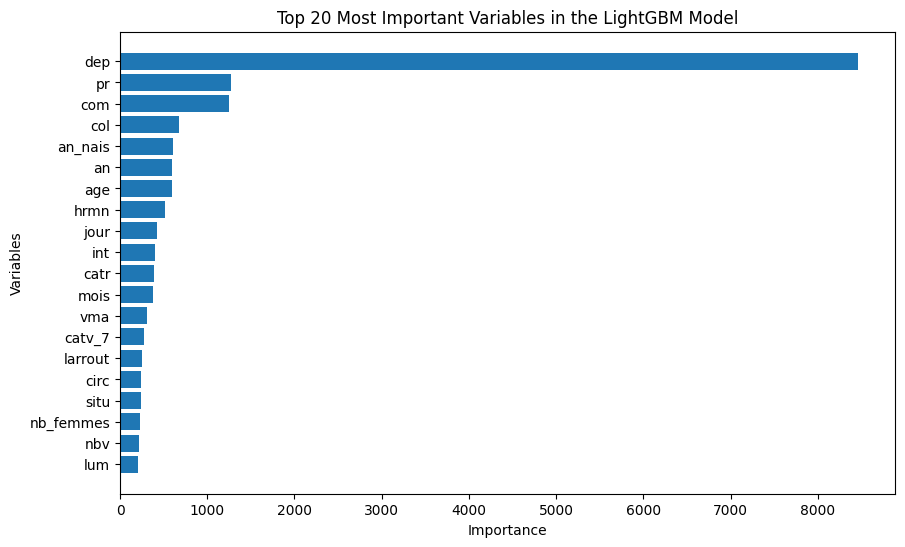

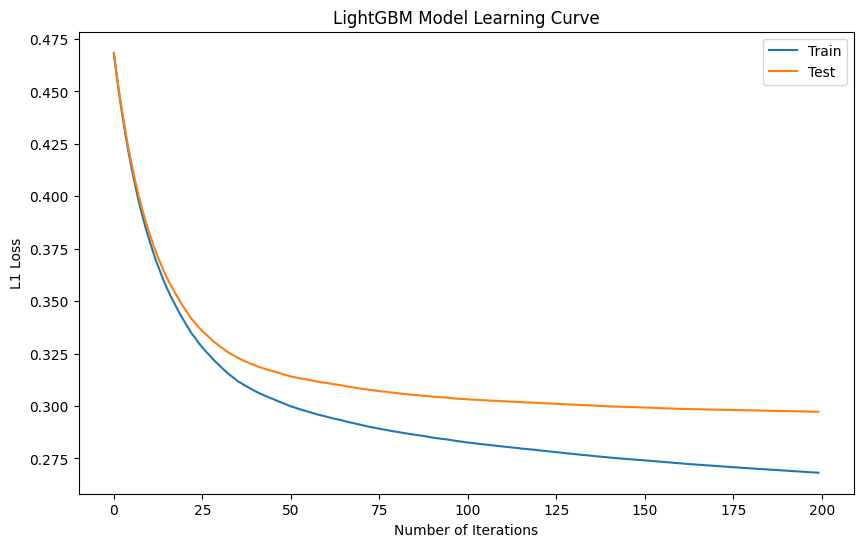

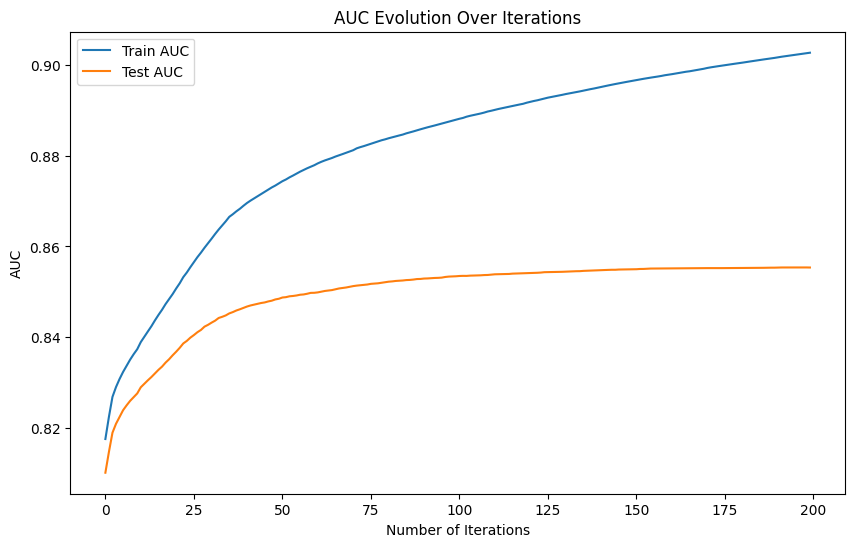

In [323]:
feature_imp_df,model = training_model(lgb_model,X,y)

# **PREDICTIONS :**

In [324]:
caracteristics_test = pd.read_csv('TEST/CARACTERISTIQUES.csv',delimiter = ',')

C:\Users\lucie\AppData\Local\Temp\ipykernel_16036\407183986.py:1: DtypeWarning: Columns (4,10,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  caracteristics_test = pd.read_csv('TEST/CARACTERISTIQUES.csv',delimiter = ',')


In [325]:
users_test = pd.read_csv('TEST/USAGERS.csv',delimiter = ',')

C:\Users\lucie\AppData\Local\Temp\ipykernel_16036\1547193871.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  users_test = pd.read_csv('TEST/USAGERS.csv',delimiter = ',')


In [326]:
vehicles_test = pd.read_csv('TEST/VEHICULES.csv',delimiter = ',')

C:\Users\lucie\AppData\Local\Temp\ipykernel_16036\1313023364.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicles_test = pd.read_csv('TEST/VEHICULES.csv',delimiter = ',')


In [327]:
localisation_test = pd.read_csv('TEST/LIEUX.csv',delimiter = ',')

C:\Users\lucie\AppData\Local\Temp\ipykernel_16036\2949266519.py:1: DtypeWarning: Columns (7,8,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  localisation_test = pd.read_csv('TEST/LIEUX.csv',delimiter = ',')


In [328]:
users_test = feature_engineering_users(users_test)

vehicles_test = feature_engineering_vehicles(vehicles_test)

caracteristics_test = feature_engineering_caracteristics(caracteristics_test)

localisation_test = feature_engineering_localisation(localisation_test)

C:\Users\lucie\AppData\Local\Temp\ipykernel_16036\2146645702.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['an_nais'].fillna(median_an_nais, inplace=True)


In [329]:
df = users_test.merge(vehicles_test,on = 'Num_Acc',how  = 'left')
df = caracteristics_test.merge(df,on = 'Num_Acc',how  = 'left')
df = localisation_test.merge(df,on = 'Num_Acc',how  = 'left')

In [330]:
df = df[list_features]

In [331]:
len(list_features)

190

In [332]:
# Check if each element in list_features is a column in df
missing_columns = [col for col in list_features if col not in df.columns]
extra_columns = [col for col in df.columns if col not in list_features]

print("Missing columns in df:", missing_columns)
print("Extra columns in df:", extra_columns)

Missing columns in df: []
Extra columns in df: []


In [333]:
# Assuming df is your DataFrame
column_names = df.columns

# Use collections.Counter to count the occurrences of each column name
from collections import Counter
column_count = Counter(column_names)

# Filter to find duplicated columns
duplicates = {item: count for item, count in column_count.items() if count > 1}

print("Duplicated columns and their number of occurrences:")
for column, count in duplicates.items():
    print(f"{column}: {count}")

Duplicated columns and their number of occurrences:


In [334]:
X = df.drop('Num_Acc',axis = 1)

In [335]:
y_pred_new = model.predict(X)
probabilities_new = model.predict_proba(X)[:, 1] 

In [336]:
results = pd.DataFrame({
    'Num_Acc': df['Num_Acc'],
    'GRAVE': probabilities_new
})

In [337]:
results.to_csv('LIGHTGBM_ALLFEATURES.csv',sep = ',', index = False)